In [15]:
# data inspection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

df = pd.read_csv("Housing.csv")

print("df.head():")
print(df.head())

print("\ndf.info():")
df.info()

print("\ndf.describe():")
print(df.describe())

print("\nMissing values:")
print(df.isnull().sum())

df.head():
      price  area  bedrooms  bathrooms  stories mainroad guestroom basement  \
0  13300000  7420         4          2        3      yes        no       no   
1  12250000  8960         4          4        4      yes        no       no   
2  12250000  9960         3          2        2      yes        no      yes   
3  12215000  7500         4          2        2      yes        no      yes   
4  11410000  7420         4          1        2      yes       yes      yes   

  hotwaterheating airconditioning  parking prefarea furnishingstatus  
0              no             yes        2      yes        furnished  
1              no             yes        3       no        furnished  
2              no              no        2      yes   semi-furnished  
3              no             yes        3      yes        furnished  
4              no             yes        2       no        furnished  

df.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data

## 1. Introduction

loading the data
545 rows 13 cols
price is the target
looks like no missing values so thats good
mainroad guestroom etc are text i'll have to change those to 1s and 0s

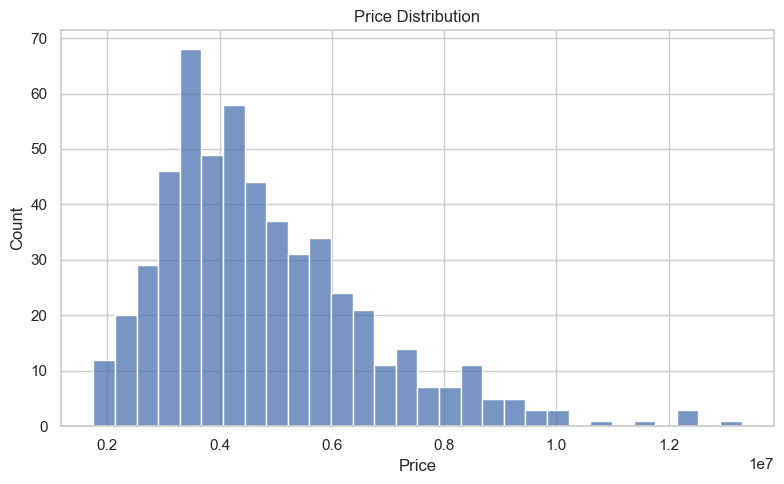

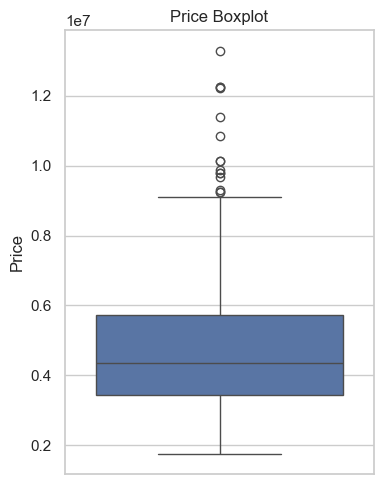

In [16]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(data=df, x="price", bins=30, ax=ax)
ax.set_title("Price Distribution")
ax.set_xlabel("Price")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(4, 5))
sns.boxplot(data=df, y="price", ax=ax)
ax.set_title("Price Boxplot")
ax.set_ylabel("Price")
plt.tight_layout()
plt.show()

## 2. EDA

price plot is skewed right
the linear model wont like that
ill have to scale it later

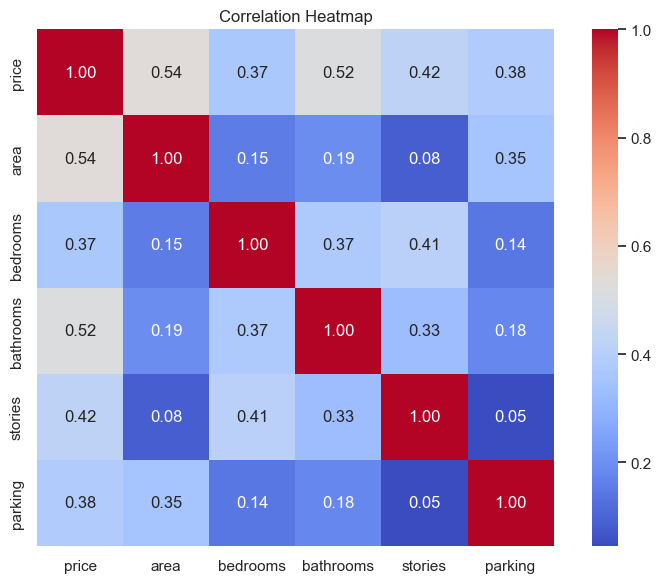

In [17]:
numeric_df = df.select_dtypes(include=["int64", "float64"])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

heatmap shows area and bathrooms are the most correlated with price
no surprise there

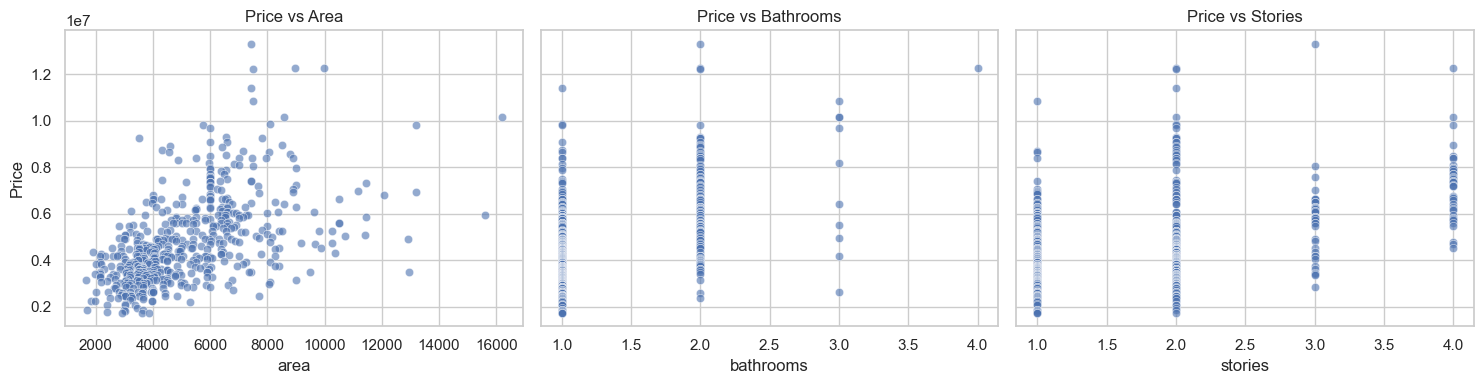

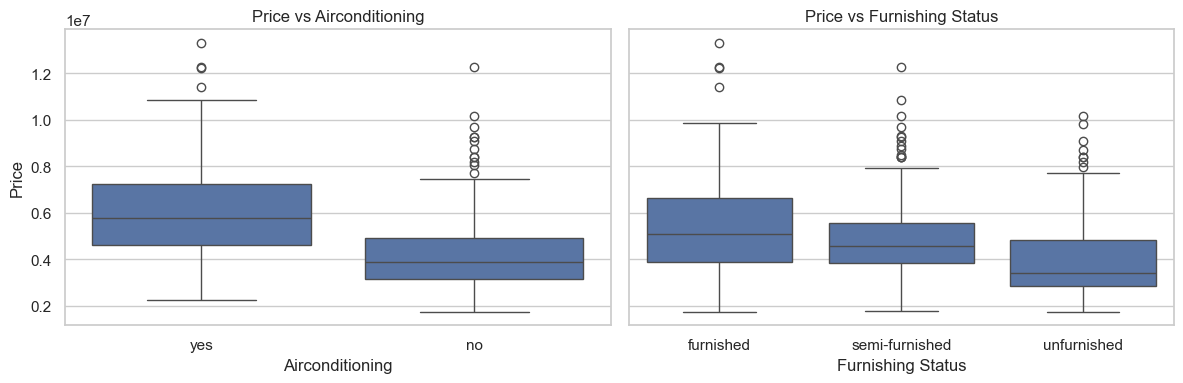

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
scatter_features = ["area", "bathrooms", "stories"]
for ax, feature in zip(axes, scatter_features):
    sns.scatterplot(data=df, x=feature, y="price", ax=ax, alpha=0.6)
    ax.set_title(f"Price vs {feature.title()}")
    ax.set_ylabel("Price")
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
sns.boxplot(data=df, x="airconditioning", y="price", ax=axes[0])
axes[0].set_title("Price vs Airconditioning")
axes[0].set_xlabel("Airconditioning")
axes[0].set_ylabel("Price")

sns.boxplot(data=df, x="furnishingstatus", y="price", ax=axes[1])
axes[1].set_title("Price vs Furnishing Status")
axes[1].set_xlabel("Furnishing Status")
axes[1].set_ylabel("Price")
plt.tight_layout()
plt.show()

plots confirm the obvious
more area more bathrooms and ac makes the price go up
furnishing status also makes a difference

## 3. Preprocessing
converting categories to numbers now
mapped all the yes/no columns to 1s and 0s
furnishingstatus has 3 levels so i used get_dummies for that
then split the data 80 20
made the scaled version for the linear model

In [19]:
df_model = df.copy()
yn_columns = ["mainroad", "guestroom", "basement", "hotwaterheating", "airconditioning", "prefarea"]
df_model[yn_columns] = df_model[yn_columns].apply(lambda col: col.map({"yes": 1, "no": 0}))

In [20]:
furnishing_dummies = pd.get_dummies(df_model["furnishingstatus"], drop_first=True)
df_model = pd.concat([df_model.drop(columns=["furnishingstatus"]), furnishing_dummies], axis=1)

In [21]:
X = df_model.drop(columns=["price"])
y = df_model["price"]

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# scaled array for linear model
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("X_train_scaled first 5 rows")
display(pd.DataFrame(X_train_scaled[:5], columns=X.columns))

X_train_scaled first 5 rows


,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,semi-furnished,unfurnished
0,0.384168,0.055271,1.539173,2.587644,0.407155,-0.466773,-0.746420,-0.230521,1.501243,0.367957,-0.552620,-0.870669,-0.676900
1,0.929181,0.055271,1.539173,-0.912499,0.407155,-0.466773,1.339728,-0.230521,1.501243,2.709987,-0.552620,1.148542,-0.676900
2,-0.607755,-1.283514,-0.557950,-0.912499,0.407155,-0.466773,1.339728,-0.230521,1.501243,1.538972,-0.552620,-0.870669,-0.676900
3,-1.155492,0.055271,-0.557950,0.254215,0.407155,-0.466773,1.339728,-0.230521,-0.666115,-0.803059,1.809561,-0.870669,1.477322
4,-0.637730,0.055271,-0.557950,0.254215,0.407155,-0.466773,-0.746420,-0.230521,-0.666115,-0.803059,-0.552620,-0.870669,1.477322


## 4. Modeling
training the models

linear regression (baseline) running this on the scaled data

random forest running  on the original data since trees dont need scaling

In [24]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)  #  scaled features

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [25]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred_lr = lr_model.predict(X_test_scaled)  # scaled test
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print(f"Linear Regression R-squared {r2_lr:.4f}")
print(f"Linear Regression RMSE {rmse_lr:,.2f}")

Linear Regression R-squared 0.6529
Linear Regression RMSE 1,324,506.96


In [26]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train) # tree on original feature scale

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [27]:
y_pred_rf = rf_model.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"Random Forest R-squared {r2_rf:.4f}")
print(f"Random Forest RMSE {rmse_rf:,.2f}")

Random Forest R-squared 0.6114
Random Forest RMSE 1,401,496.84


Both models were evaluated on the same set:

- Linear Regression R-squared ≈ 0.653, RMSE ≈ 1.32M
- Random Forest R-squared ≈ 0.611, RMSE ≈ 1.40M

Despite the expectation that the Rand Forest would dominate, the linear model had a slight edge, I think it is likely because the relationships between features and price are close to linear after encoding

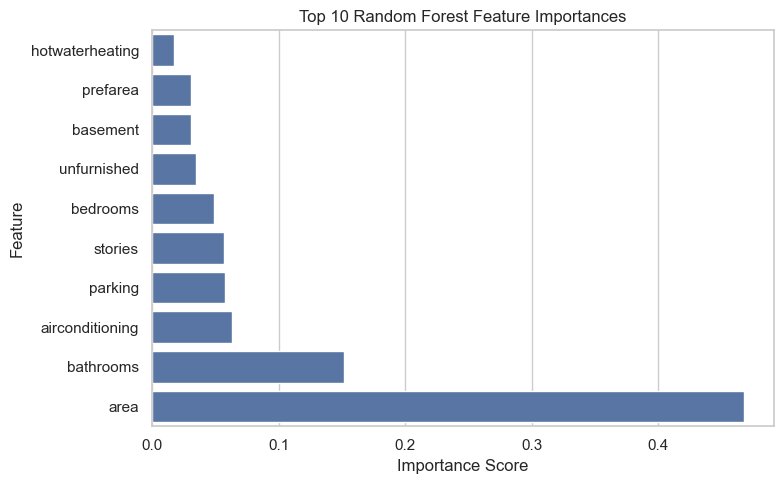

In [28]:
feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
top_features = feature_importances.sort_values(ascending=False).head(10).sort_values()

plt.figure(figsize=(8, 5))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title("Top 10 Random Forest Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

this is what the random forest model thinks is important, area is still the biggest factor just like the heatmap showed

## 5. Conclusion

This project aimed to predict housing prices, two models were used, Linear Regression and Random Forest.
So the linear regression model was actually a better (rmse 1.32m) than the random forest (1.40m)
wasnt expecting that but the data is pretty simple
eda was right
The most influential features were area, bathrooms, airconditioning, parking, and stories, which aligns with the earlier EDA insights that space and amenities drive value.
The right skewed target confirms that a log transform may stabilize variance for linear models.
If I had more time I'd tune the models or try the log transform on price but this is good for now

Next Steps: Explore hyperparameter tuning, experiment with log-transformed targets, and evaluate additional ensemble methods to squeeze out more prediction.